In [3]:
# non overlapping block bootstrap
import numpy as np #bootstrapping 1000 times 
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout
from keras import backend as tf

df=pd.read_csv("C:\\Users\\shankhajyoti\\Dropbox\\Deepak\\GOOGL_data.csv")
data_csv=df
 
#how many data we will use 
# (should not be more than dataset length )
data_to_use= len(data_csv)
 
# number of training data
# should be less than data_to_use
train_end =len(data_csv)-458
 
 
total_data=len(data_csv)
 
#most recent data is in the end 
#so need offset
start=total_data - data_to_use
 
 
#currently doing prediction only for 1 step ahead
steps_to_predict =1
 
  
yt = data_csv.iloc [start:total_data ,4]    #Close price
yt1 = data_csv.iloc [start:total_data ,1]   #Open
yt2 = data_csv.iloc [start:total_data ,2]   #High
yt3 = data_csv.iloc [start:total_data ,3]   #Low
vt = data_csv.iloc [start:total_data ,5]    # volume
 
 
print ("yt head :")
print (yt.head())
 
yt_ = yt.shift (-1)
     
data = pd.concat ([yt, yt_, vt, yt1, yt2, yt3], axis =1)
data. columns = ['yt', 'yt_', 'vt', 'yt1', 'yt2', 'yt3']
     
data = data.dropna()
     
print (data)
     
# target variable - closed price
# after shifting
#y = data ['yt_']
#print (y) 
        
#       closed,  volume,   open,  high,   low  

cols =['yt']
#x = data [cols]
rmse_mean_trainset=0.0
rmse_mean_testset=0.0
n_bootstrap=4
testset_array=np.zeros(shape=(n_bootstrap,458))
testset_array_sorted=np.zeros(shape=(n_bootstrap,458))

ci_lowerbound=np.zeros(shape=(1,458))
ci_upperbound=np.zeros(shape=(1,458))
n=800

nbb_listx=pd.DataFrame() 

for idx in range(n_bootstrap):
 l1=2 #optimal block length 
 
 n=800
 N=n//l1
 if(n!=N*l1):
    N=N+1
 array=np.zeros((N,1),dtype=np.int)

 for i in range(N):
    array[i,0]=i
 arr=array.reshape(len(array))
 n_elements=0
 while(n_elements<n):
        j=np.random.choice(arr,replace=True)
        print (j)
        if(j!=N-1):
            n_elements=n_elements+l1
            for i in range(l1):
                nbb_listx=nbb_listx.append(data.iloc[j*l1+i,:],ignore_index=True)
        else:
            n_elements=n_elements+n-(N-1)*l1
            for i in range((N-1)*l1,n):
                nbb_listx=nbb_listx.append(data.iloc[i,:],ignore_index=True)
 x_train=nbb_listx[cols]   
 x_test=data[cols].loc[800:1257,:]
 y_train=nbb_listx['yt_']
 y_test=data['yt_'].loc[800:1257]
 nbb_listx=nbb_listx.iloc[0:0,0:0]
 scaler_x_train = preprocessing.MinMaxScaler ( feature_range =( -1, 1))
 x_train = np. array (x_train).reshape ((len( x_train) ,len(cols)))
 x_train_copy=x_train


 smoothing_window_size = 320
 for di in range(0,800,smoothing_window_size):
     scaler_x_train.fit(x_train[di:di+smoothing_window_size,:])
     x_train[di:di+smoothing_window_size,:] = scaler_x_train.transform(x_train[di:di+smoothing_window_size,:])
 

 x_test = np. array (x_test).reshape ((len( x_test) ,len(cols)))
 x_test=scaler_x_train.transform(x_test)

 x_train = x_train.reshape (x_train. shape + (1,)) 
 x_test = x_test.reshape (x_test. shape + (1,))




 scaler_y_train = preprocessing. MinMaxScaler ( feature_range =( -1, 1))
 y_train = np.array (y_train).reshape ((len( y_train),1 ))
 y_train_copy=y_train

 smoothing_window_size = 320
 for di in range(0,800,smoothing_window_size):
     scaler_y_train.fit(y_train[di:di+smoothing_window_size,:])
     y_train[di:di+smoothing_window_size,:] = scaler_y_train.transform(y_train[di:di+smoothing_window_size,:])


 y_test = np. array (y_test).reshape ((len( y_test) ,1))



    

 
    

 
     
     
 
 
 
 
 
 
 
 
 fit1 = Sequential ()
 fit1.add (LSTM (  1000 , activation = 'tanh', inner_activation = 'hard_sigmoid' , input_shape =(len(cols), 1) ))
 fit1.add(Dropout(0.2))
 fit1.add (Dense (output_dim =1, activation = 'linear'))
 
 fit1.compile (loss ="mean_squared_error" , optimizer = "adam")   
 fit1.fit (x_train, y_train, batch_size =20, nb_epoch =20, shuffle = False)
 
##print (fit1.summary())
 x_train_copy = np.array(x_train_copy).reshape (x_train_copy. shape + (1,)) 

 pred1 = fit1.predict (x_train_copy) 
 pred1=np.array(pred1).reshape((len(pred1),1))
 sum=0.0
 for i in range(len(y_train)):
     sum=sum+(y_train_copy[i,0]-pred1[i,0])**2

    
 sum1=(sum/len(y_train))**0.5
 rmse_mean_trainset=rmse_mean_trainset+sum1

 pred1 = fit1.predict (x_test)
 pred1 = scaler_y_train.inverse_transform (np. array (pred1). reshape ((len( pred1), 1)))    

 sum=0.0
 for i in range(len(y_test)):
     sum=sum+(y_test[i,0]-pred1[i,0])**2

    
 sum=(sum/len(y_test))**0.5
 pred1=np.array(pred1).reshape(1,len(pred1))
 testset_array[idx,:]=pred1
 rmse_mean_testset=rmse_mean_testset+sum
 print("rmse_train  rmse_test",sum1,sum)
 tf.clear_session()
 
  
rmse_mean_trainset=rmse_mean_trainset/n_bootstrap
rmse_mean_testset=rmse_mean_testset/n_bootstrap
print("rmse_final_train  ",rmse_mean_trainset)
print("rmse_final_test",rmse_mean_testset) 
testset_array_sorted=np.sort(testset_array,axis=0,kind='quicksort')  
avg_pred=np.sum(testset_array_sorted,axis=0)     
avg_pred=avg_pred/n_bootstrap 
avg_pred=np.array(avg_pred).reshape(458,1)
ci_lowerbound[0,:]=testset_array_sorted[0,:] 
ci_upperbound[0,:]=testset_array_sorted[3,:]
ci_upperbound=np.array(ci_upperbound).reshape(458,1)
ci_lowerbound=np.array(ci_lowerbound).reshape(458,1)
comparing_factor=np.sum(ci_upperbound,axis=0)-np.sum(ci_lowerbound,axis=0)

print("comparing factor",comparing_factor)

 

import matplotlib.ticker as mtick
fmt = '$%.0f'
tick = mtick.FormatStrFormatter(fmt)
 
ax = plt.axes()
ax.yaxis.set_major_formatter(tick)
  
 
plt.plot(avg_pred, label="avg_predictions")
 
 

plt.plot( [row[0] for row in y_test], label="actual")
plt.plot(ci_lowerbound,label="lowerbound_ci")
plt.plot(ci_upperbound,label="upperbound_ci")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)
 

 
plt.show()


yt head :
0    393.0777
1    391.6012
2    390.7403
3    391.8214
4    394.3039
Name: close, dtype: float64
             yt        yt_       vt        yt1        yt2        yt3
0      393.0777   391.6012  6031199   390.4551   393.7283   390.1698
1      391.6012   390.7403  4330781   389.5892   391.8915   387.2619
2      390.7403   391.8214  3714176   391.2659   394.3440   390.0747
3      391.8214   394.3039  2393946   390.4551   393.0677   390.3750
4      394.3039   396.8414  3466971   390.2549   394.7644   389.2739
5      396.8414   403.8284  5453980   394.0937   397.0266   393.9285
6      403.8284   396.6262  5857528   398.3930   403.9035   398.0376
7      396.6262   398.1628  5522500   403.0527   404.8895   396.2929
8      398.1628   400.2549  7008464   399.3990   403.1277   396.0056
9      400.2549   395.7804  4103315   400.0296   401.0256   397.2969
10     395.7804   395.4601  4602925   401.5512   404.6092   395.6402
11     395.4601   400.2899  4399988   397.8975   398.3729   392.

C:\Users\shankhajyoti\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:156: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(1000, activation="tanh", input_shape=(1, 1), recurrent_activation="hard_sigmoid")`
C:\Users\shankhajyoti\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:158: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
C:\Users\shankhajyoti\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:161: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/20
800/800 [==============================] - 16s 20ms/step - loss: 0.1392
Epoch 2/20
800/800 [==============================] - 8s 11ms/step - loss: 0.0066
Epoch 3/20
800/800 [==============================] - 8s 11ms/step - loss: 0.0026
Epoch 4/20
800/800 [==============================] - 8s 10ms/step - loss: 0.0027
Epoch 5/20
800/800 [==============================] - 8s 10ms/step - loss: 0.0026
Epoch 6/20
800/800 [==============================] - 8s 10ms/step - loss: 0.0026
Epoch 7/20
800/800 [==============================] - 8s 10ms/step - loss: 0.0025
Epoch 8/20
800/800 [==============================] - 8s 10ms/step - loss: 0.0027: 1s - loss: 0
Epoch 9/20
800/800 [==============================] - 8s 10ms/step - loss: 0.0026
Epoch 10/20
800/800 [==============================] - 8s 10ms/step - loss: 0.0026
Epoch 11/20
800/800 [==============================] - 8s 10ms/step - loss: 0.0027: 0s - loss: 0.
Epoch 12/20
800/800 [==============================] - 8s 11ms/ste

C:\Users\shankhajyoti\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:156: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(1000, activation="tanh", input_shape=(1, 1), recurrent_activation="hard_sigmoid")`
C:\Users\shankhajyoti\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:158: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
C:\Users\shankhajyoti\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:161: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/20
800/800 [==============================] - 11s 14ms/step - loss: 0.1538
Epoch 2/20
800/800 [==============================] - 8s 10ms/step - loss: 0.0089
Epoch 3/20
800/800 [==============================] - 8s 11ms/step - loss: 0.0043
Epoch 4/20
800/800 [==============================] - 8s 10ms/step - loss: 0.0040
Epoch 5/20
800/800 [==============================] - 9s 11ms/step - loss: 0.0038
Epoch 6/20
800/800 [==============================] - 9s 11ms/step - loss: 0.0037
Epoch 7/20
800/800 [==============================] - 9s 12ms/step - loss: 0.0038
Epoch 8/20
800/800 [==============================] - 9s 11ms/step - loss: 0.0038
Epoch 9/20
800/800 [==============================] - 8s 10ms/step - loss: 0.0038
Epoch 10/20
800/800 [==============================] - 8s 11ms/step - loss: 0.0038
Epoch 11/20
800/800 [==============================] - 8s 11ms/step - loss: 0.0037
Epoch 12/20
800/800 [==============================] - 8s 11ms/step - loss: 0.0038
Epoch 13/20


C:\Users\shankhajyoti\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:156: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(1000, activation="tanh", input_shape=(1, 1), recurrent_activation="hard_sigmoid")`
C:\Users\shankhajyoti\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:158: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
C:\Users\shankhajyoti\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:161: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/20
800/800 [==============================] - 12s 15ms/step - loss: 0.1366
Epoch 2/20
460/800 [================>.............] - ETA: 3s - loss: 0.0082

KeyboardInterrupt: 

yt head :
0    393.0777
1    391.6012
2    390.7403
3    391.8214
4    394.3039
Name: close, dtype: float64
             yt        yt_       vt        yt1        yt2        yt3
0      393.0777   391.6012  6031199   390.4551   393.7283   390.1698
1      391.6012   390.7403  4330781   389.5892   391.8915   387.2619
2      390.7403   391.8214  3714176   391.2659   394.3440   390.0747
3      391.8214   394.3039  2393946   390.4551   393.0677   390.3750
4      394.3039   396.8414  3466971   390.2549   394.7644   389.2739
5      396.8414   403.8284  5453980   394.0937   397.0266   393.9285
6      403.8284   396.6262  5857528   398.3930   403.9035   398.0376
7      396.6262   398.1628  5522500   403.0527   404.8895   396.2929
8      398.1628   400.2549  7008464   399.3990   403.1277   396.0056
9      400.2549   395.7804  4103315   400.0296   401.0256   397.2969
10     395.7804   395.4601  4602925   401.5512   404.6092   395.6402
11     395.4601   400.2899  4399988   397.8975   398.3729   392.

C:\Users\shankhajyoti\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:173: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(1000, activation="tanh", batch_input_shape=(15, 5, 1), recurrent_activation="hard_sigmoid")`
C:\Users\shankhajyoti\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:177: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
C:\Users\shankhajyoti\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:182: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
795/795 [==============================] - 24s 30ms/step - loss: 0.2472
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (15, 1000)                4008000   
_________________________________________________________________
dropout_1 (Dropout)          (15, 1000)                0         
_________________________________________________________________
dense_1 (Dense)              (15, 1)                   1001      
Total params: 4,009,001
Trainable params: 4,009,001
Non-trainable params: 0
_________________________________________________________________
None
rmse_train  rmse_test 0.4433630154130905 237.89973146753837


C:\Users\shankhajyoti\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:173: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(1000, activation="tanh", batch_input_shape=(15, 5, 1), recurrent_activation="hard_sigmoid")`
C:\Users\shankhajyoti\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:177: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
C:\Users\shankhajyoti\Anaconda2\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:182: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
795/795 [==============================] - 25s 31ms/step - loss: 0.2482
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (15, 1000)                4008000   
_________________________________________________________________
dropout_1 (Dropout)          (15, 1000)                0         
_________________________________________________________________
dense_1 (Dense)              (15, 1)                   1001      
Total params: 4,009,001
Trainable params: 4,009,001
Non-trainable params: 0
_________________________________________________________________
None
rmse_train  rmse_test 0.4440454236127948 238.5267873573915
rmse_final_train   0.44370421951294264
rmse_final_test 238.21325941246494
comparing factor [251.37103271]


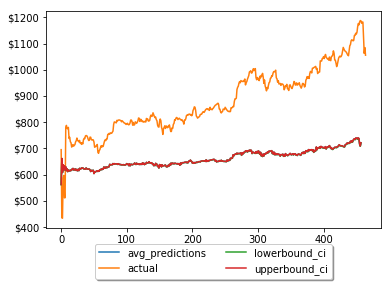

In [2]:
import numpy as np #bootstrapping 1000 times to compare by checking difference between upper and lower bounds of confidence intervals#
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout
from keras import backend as tf
from pandas import DataFrame
from pandas import concat
df=pd.read_csv("C:\\Users\\shankhajyoti\\Dropbox\\Deepak\\GOOGL_data.csv")
data_csv=df
 
#how many data we will use 
# (should not be more than dataset length )
data_to_use= len(data_csv)
 
# number of training data
# should be less than data_to_use
train_end =len(data_csv)-458
 
 
total_data=len(data_csv)
 
#most recent data is in the end 
#so need offset
start=total_data - data_to_use
 
 
#currently doing prediction only for 1 step ahead
steps_to_predict =1
 
  
yt = data_csv.iloc [start:total_data ,4]    #Close price
yt1 = data_csv.iloc [start:total_data ,1]   #Open
yt2 = data_csv.iloc [start:total_data ,2]   #High
yt3 = data_csv.iloc [start:total_data ,3]   #Low
vt = data_csv.iloc [start:total_data ,5]    # volume
 
 
print ("yt head :")
print (yt.head())
 
yt_ = yt.shift (-1)
     
data = pd.concat ([yt, yt_, vt, yt1, yt2, yt3], axis =1)
data. columns = ['yt', 'yt_', 'vt', 'yt1', 'yt2', 'yt3']
     
data = data.dropna()
     
print (data)
     
# target variable - closed price
# after shifting
#y = data ['yt_']
#print (y) 
        
#       closed,  volume,   open,  high,   low  

cols =['yt']
#x = data [cols]
rmse_mean_trainset=0.0
rmse_mean_testset=0.0
n_bootstrap=1000
testset_array=np.zeros(shape=(n_bootstrap,458))
testset_array_sorted=np.zeros(shape=(n_bootstrap,458))

ci_lowerbound=np.zeros(shape=(1,458))
ci_upperbound=np.zeros(shape=(1,458))
n=800
b=1
B=0.01
mbb_listx=pd.DataFrame() 
#lbb_listy=pd.DataFrame()
for idx in range(n_bootstrap):
   
 l1=2 #optimal block length 
 
 n=800
 N=n//l1
 if(n!=N*l1):
    N=N+1
 array=np.zeros((N,1),dtype=np.int)

 for i in range(N):
    array[i,0]=i
 arr=array.reshape(len(array))
 n_elements=0
 while(n_elements<n):
        j=np.random.choice(arr,replace=True)
        if(j!=N-1):
            n_elements=n_elements+l1
            for i in range(l1):
                nbb_listx=nbb_listx.append(data.iloc[j*l1+i,:],ignore_index=True)
        else:
            n_elements=n_elements+n-(N-1)*l1
            for i in range((N-1)*l1,n):
                nbb_listx=nbb_listx.append(data.iloc[i,:],ignore_index=True)
 
#print(lbb_listx) 
 x_train=nbb_listx[cols]   
 x_test=data[cols].loc[800:1257,:]
 y_train=nbb_listx['yt_']
 y_test=data['yt_'].loc[800:1257]
 nbb_listx=nbb_listx.iloc[0:0,0:0]
 timesteps=5
 n_batch=15
 scaler_x_train = preprocessing.MinMaxScaler ( feature_range =( -1, 1))
 x_train = np. array (x_train).reshape ((len( x_train) ,len(cols)))
 x_train_copy=x_train
 smoothing_window_size = 320
 for di in range(0,800,smoothing_window_size):
    scaler_x_train.fit(x_train[di:di+smoothing_window_size,:])
    x_train[di:di+smoothing_window_size,:] = scaler_x_train.transform(x_train[di:di+smoothing_window_size,:])

    
 x_test = np. array (x_test).reshape ((len( x_test) ,len(cols)))
 x_test_copy=x_test
 x_test=scaler_x_train.transform(x_test)

 x_train = x_train.reshape (len(x_train),1) 
 x_test = x_test.reshape (len(x_test),1)
    

    
    
    
    
    
    
 scaler_y_train = preprocessing. MinMaxScaler ( feature_range =( -1, 1))
 y_train = np.array (y_train).reshape ((len( y_train), 1))
 y_train_copy=y_train
 smoothing_window_size = 320
 for di in range(0,800,smoothing_window_size):
    scaler_y_train.fit(y_train[di:di+smoothing_window_size,:])
    y_train[di:di+smoothing_window_size,:] = scaler_y_train.transform(y_train[di:di+smoothing_window_size,:])
    


 y_test = np. array (y_test).reshape ((len( y_test) ,1))
 y_test=scaler_y_train.transform(y_test)
 A=np.append(y_train,y_test,axis=0)
 A=np.array(A).reshape(len(y_train)+len(y_test),1)
 lag=timesteps
 df = DataFrame(A)

 columns = [df.shift(i) for i in range(lag,0,-1)]
 columns.append(df)
 df = concat(columns, axis=1)
 df=np.array(df).reshape(len(df),timesteps+1)
 const=len(x_train)
 const2=len(x_test)
 a=n_batch-(const2-((const2//n_batch)*n_batch))

 x_train=df[timesteps:len(x_train),0:-1]
 y_train=df[timesteps:const,-1]
 x_test=df[const-a:const+const2,0:-1]
 y_test=df[const-a:const+const2,-1]


 
     
     
 

 
 
 fit1 = Sequential ()
 fit1.add (LSTM (  1000 , activation = 'tanh', inner_activation = 'hard_sigmoid' , batch_input_shape =(n_batch,timesteps, 1) ))
 fit1.add(Dropout(0.2))


 fit1.add (Dense (output_dim =1, activation = 'linear'))
 
 fit1.compile (loss ="mean_squared_error" , optimizer = "adam")   
 x_train=np.array(x_train).reshape(len(x_train),timesteps,1)

 fit1.fit (x_train, y_train, batch_size =n_batch, nb_epoch =20, shuffle = False)
 
 print (fit1.summary())
 y_test=np.array(y_test).reshape(const2+a,1)
 A=np.append(y_train_copy,y_test,axis=0)
 A=np.array(A).reshape(len(y_train_copy)+len(y_test),1)
 lag=timesteps
 df = DataFrame(A)    
    
 columns = [df.shift(i) for i in range(lag,0,-1)]
 columns.append(df)
 df = concat(columns, axis=1)
 df=np.array(df).reshape(len(df),timesteps+1)
 x_train_copy=df[timesteps:const,0:-1]
 y_train_copy=df[timesteps:const,-1]

 x_train_copy=np.array(x_train_copy).reshape(len(x_train_copy),timesteps,1)

 pred1= fit1.predict(x_train_copy,batch_size=n_batch)
 pred1=np.array(pred1).reshape(len(pred1),1)
 y_train_copy=np.array(y_train_copy).reshape(len(pred1),1)


 sum=0.0
 for i in range(len(y_train_copy)):
    sum=sum+(y_train_copy[i,0]-pred1[i,0])**2

    
 sum1=(sum/len(y_train))**0.5
 rmse_mean_trainset=rmse_mean_trainset+sum1
 
 x_test=np.array(x_test).reshape(len(x_test),timesteps,1)
 pred1=fit1.predict(x_test,batch_size=n_batch) 
 
 pred1 = scaler_y_train.inverse_transform (np. array (pred1). reshape ((len( pred1), 1)))

 y_test = scaler_y_train.inverse_transform (np. array (y_test). reshape ((len( pred1), 1)))
 sum=0.0
 for i in range(a,len(y_test),1):
    sum=sum+(y_test[i,0]-pred1[i,0])**2

    
 sum=(sum/len(y_test)-a)**0.5
 
 for q in range(a,len(pred1),1):
    testset_array[idx,q-a]=pred1[q,0]
 rmse_mean_testset=rmse_mean_testset+sum
 print("rmse_train  rmse_test",sum1,sum)
 tf.clear_session()
 


      
    
 
 
 
  
rmse_mean_trainset=rmse_mean_trainset/n_bootstrap
rmse_mean_testset=rmse_mean_testset/n_bootstrap
print("rmse_final_train  ",rmse_mean_trainset)
print("rmse_final_test",rmse_mean_testset) 
testset_array_sorted=np.sort(testset_array,axis=0,kind='quicksort')  
avg_pred=np.sum(testset_array_sorted,axis=0)     
avg_pred=avg_pred/n_bootstrap 
avg_pred=np.array(avg_pred).reshape(458,1)
ci_lowerbound[0,:]=testset_array_sorted[24,:] 
ci_upperbound[0,:]=testset_array_sorted[974,:]
ci_upperbound=np.array(ci_upperbound).reshape(458,1)
ci_lowerbound=np.array(ci_lowerbound).reshape(458,1)
comparing_factor=np.sum(ci_upperbound,axis=0)-np.sum(ci_lowerbound,axis=0)

print("comparing factor",comparing_factor)

 

import matplotlib.ticker as mtick
fmt = '$%.0f'
tick = mtick.FormatStrFormatter(fmt)
 
ax = plt.axes()
ax.yaxis.set_major_formatter(tick)
  
 
plt.plot(avg_pred, label="avg_predictions")
 
 

plt.plot( [row[0] for row in y_test], label="actual")
plt.plot(ci_lowerbound,label="lowerbound_ci")
plt.plot(ci_upperbound,label="upperbound_ci")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)
 

 
plt.show()
